## Custom Model

In [1]:
from tensorflow import keras
from keras.layers import MaxPooling2D, BatchNormalization, Activation, Conv2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.layers import Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import GlobalAveragePooling2D
import cv2


In [2]:
# for pytorch
import torchvision
import torchvision.transforms as transforms

# Define data transformations ( optional , but recommended )
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5 , 0.5 , 0.5), (0.5 , 0.5 , 0.5))])

# Load the training dataset
train_dataset = torchvision.datasets.CIFAR10(root ='./data', train = True, transform = transform, download = True)
# Load the testing dataset
test_dataset = torchvision.datasets.CIFAR10(root ='./data', train = False, transform = transform, download = True)

# for keras
from keras.datasets import cifar10

# Load the CIFAR -10 dataset
(train_images , train_labels), (test_images, test_labels) = cifar10.load_data()


Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_images = train_images/255.0
test_images = test_images/255.0
train_images.shape , train_labels.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
train_labels_one_hot = to_categorical(train_labels, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)

In [5]:
# Define the model architecture
def build_model(inputs, filters, d, kernel_size = 3): 
    "filters: [x1, x2, x3]"
    x = Conv2D(filters[0], kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters[1], kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    x = Dense(filters[2], activation='relu')(x)
    x = Dropout(d)(x)
    x = Dense(10, activation='softmax')(x)

    return x


In [6]:
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)
output = build_model(inputs, filters=[64, 128, 256], d=0.01)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
history = model.fit(train_images, train_labels_one_hot, batch_size=64, epochs=10, verbose="auto", validation_split=0.2)
model.save('cifar10.h5')
print("Saved model to disk")

df = pd.DataFrame(history.history)
df.to_csv("history.csv")

Epoch 1/10
625/625 [==============================] - 67s 104ms/step - loss: 1.9477 - accuracy: 0.2492 - val_loss: 1.7012 - val_accuracy: 0.3753
Epoch 2/10
625/625 [==============================] - 67s 107ms/step - loss: 1.7829 - accuracy: 0.2964 - val_loss: 1.5552 - val_accuracy: 0.4468
Epoch 3/10
625/625 [==============================] - 70s 112ms/step - loss: 1.7147 - accuracy: 0.3314 - val_loss: 1.6161 - val_accuracy: 0.4108
Epoch 4/10
625/625 [==============================] - 67s 108ms/step - loss: 1.6771 - accuracy: 0.3471 - val_loss: 1.5566 - val_accuracy: 0.4115
Epoch 5/10
625/625 [==============================] - 71s 114ms/step - loss: 1.6492 - accuracy: 0.3593 - val_loss: 1.4221 - val_accuracy: 0.4690
Epoch 6/10
625/625 [==============================] - 84s 135ms/step - loss: 1.6256 - accuracy: 0.3703 - val_loss: 1.3936 - val_accuracy: 0.4989
Epoch 7/10
625/625 [==============================] - 82s 131ms/step - loss: 1.5989 - accuracy: 0.3793 - val_loss: 1.2564 - val_ac

c:\Users\askan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [7]:
model = keras.models.load_model('cifar10.h5')

In [8]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 12s 37ms/step - loss: 0.9047 - accuracy: 0.6974
Test accuracy: 0.6973999738693237


313/313 [==============================] - 10s 33ms/step


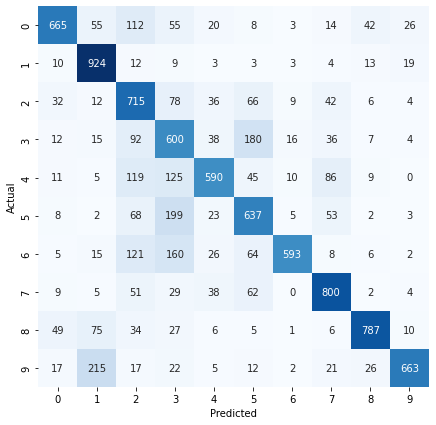

In [9]:
# Assuming you have a trained model and test data X_test
y_pred = model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


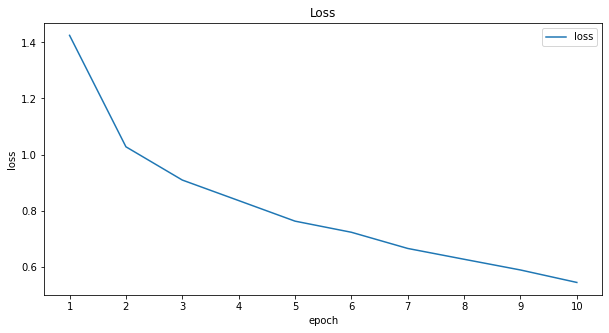

In [10]:
# reading the csv file
df = pd.read_csv('history.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 11))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

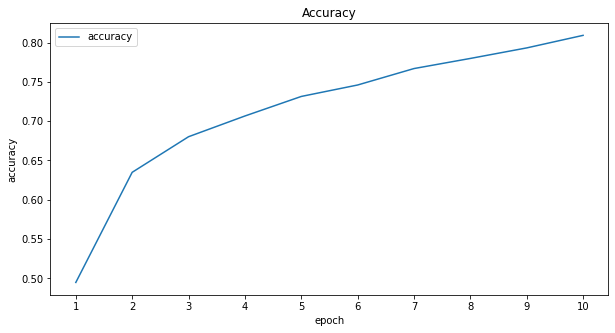

In [11]:
# reading the csv file
df = pd.read_csv('history.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='accuracy')
ax.set_xticks(np.arange(1, 11))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

In [12]:
from keras.applications.resnet50 import ResNet50, preprocess_input

# Define the model architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

## Using RESNET50

#### Model Training. this was done in Kaggle notebook with GPU enabled.

In [5]:
from keras.applications.resnet50 import ResNet50

# Define the model architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


94765736/94765736 [==============================] - 210s 2us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(10)(x)  # 10 units for CIFAR-10 classes
x = Activation('softmax')(x)

resnet_model = keras.Model(inputs=base_model.input, outputs=x)
resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_images, train_labels_one_hot, batch_size=64, epochs=20, verbose="auto", validation_split=0.2)
resnet_model.save('resnet50.h5')
print("Saved model to disk")

df = pd.DataFrame(resnet_history.history)
df.to_csv("resnet_history.csv")

#### Model Importing

In [10]:
# Load the model using custom_objects
resnet_model = keras.models.load_model('resnet50.h5', custom_objects={"accuracy": "accuracy"})

In [11]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [12]:
test_loss, test_accuracy = resnet_model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

313/313 [==============================] - 31s 96ms/step - loss: 1.4630 - accuracy: 0.7089
Test accuracy: 0.708899974822998
Test loss: 1.4630118608474731


313/313 [==============================] - 32s 98ms/step


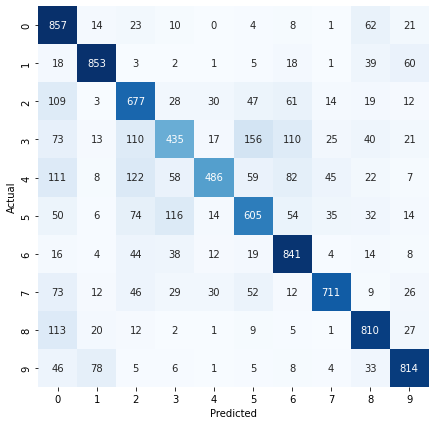

In [13]:
# Assuming you have a trained model and test data X_test
y_pred = resnet_model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

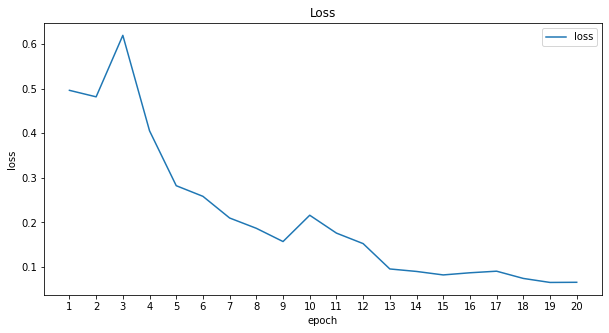

In [37]:
# reading the csv file
df = pd.read_csv('resnet_history.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

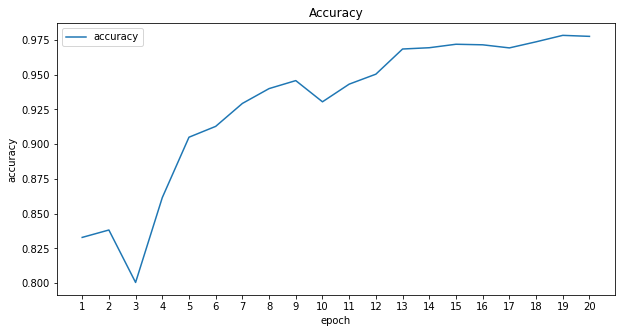

In [36]:
# reading the csv file
df = pd.read_csv('resnet_history.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

## Using GoogleNET (InceptionV3)

#### Model Training. this was done in Kaggle notebook with GPU enabled.

In [16]:
from keras.applications import InceptionV3

googlenet_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

87910968/87910968 [==============================] - 114s 1us/step


In [17]:
resized_train_images = []
resized_test_images = []

# Loop through each image in the original dataset and resize it
for image in train_images:
    resized_image = cv2.resize(image, (75, 75))
    resized_train_images.append(resized_image)
    
for image in test_images:
    resized_image = cv2.resize(image, (75, 75))
    resized_test_images.append(resized_image)

resized_train_images = np.array(resized_train_images)
resized_test_images = np.array(resized_test_images)
    
train_images.shape, resized_train_images.shape, resized_test_images.shape

((50000, 32, 32, 3), (50000, 75, 75, 3), (10000, 75, 75, 3))

In [ ]:
x = googlenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='relu')(x)

from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # Adjust the clipvalue as needed

inceptionv3_model = keras.models.Model(inputs=googlenet_model.input, outputs=x)
inceptionv3_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
inceptionv3_history = inceptionv3_model.fit(resized_train_images, train_labels_one_hot, batch_size=64, epochs=20, verbose="auto", validation_split=0.2)
inceptionv3_model.save('inceptionv3.h5')
print("Saved model to disk")

df = pd.DataFrame(inceptionv3_history.history)
df.to_csv("resnet_history.csv")

#### Model Importing

In [18]:
# Load the model using custom_objects
inceptionv3_model = keras.models.load_model('inceptionv3.h5', custom_objects={"accuracy": "accuracy"})

In [19]:
inceptionv3_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 37, 37, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 37, 37, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 37, 37, 32)           0         ['batch_normalization_18

In [20]:
evaluation = inceptionv3_model.evaluate(resized_test_images, test_labels_one_hot, verbose=1)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

313/313 [==============================] - 760s 2s/step - loss: 2.1782 - accuracy: 0.1285
Test Loss: 2.1782212257385254
Test Accuracy: 0.12849999964237213


313/313 [==============================] - 580s 2s/step


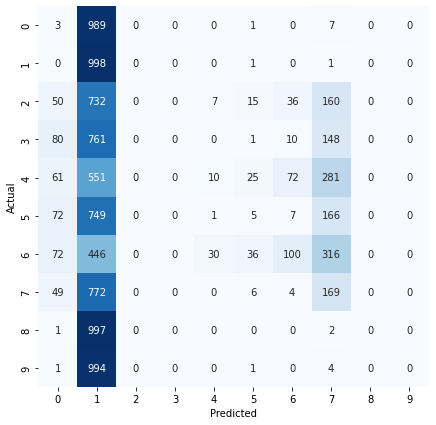

In [21]:
# Assuming you have a trained model and test data X_test
y_pred = inceptionv3_model.predict(resized_test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

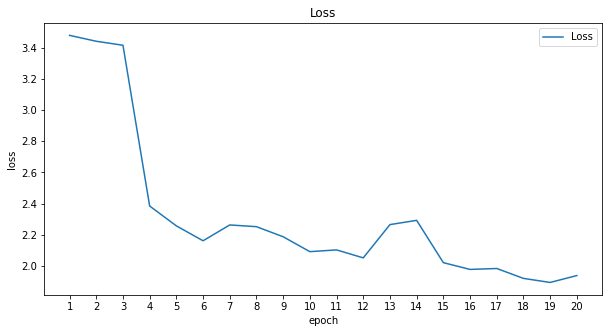

In [35]:
# reading the csv file
df = pd.read_csv('inception_history.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='Loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

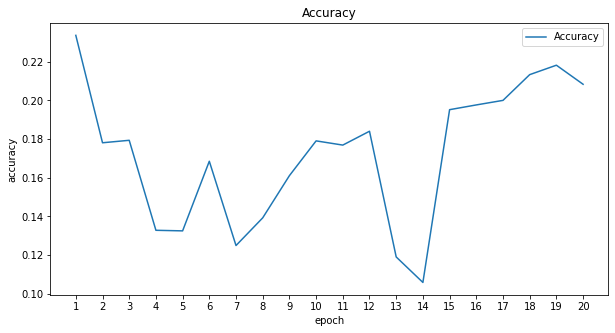

In [34]:
# reading the csv file
df = pd.read_csv('inception_history.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='Accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

## Using VGG19

#### Model Training. this was done in Kaggle notebook with GPU enabled.

In [24]:
from keras.applications import VGG19

# Load VGG19 with pre-trained weights and exclude the top layers
VGG = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

80134624/80134624 [==============================] - 72s 1us/step


In [ ]:
x = VGG.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x)  # 10 classes in CIFAR-10

VGG_model = keras.models.Model(inputs=VGG.input, outputs=x)
VGG_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
VGG_history = VGG_model.fit(train_images, train_labels_one_hot, epochs=20, batch_size=64, validation_split=0.2)
VGG_model.save('VGG19.h5')
print("Saved model to disk")

df = pd.DataFrame(VGG_history.history)
df.to_csv("VGG_history.csv")

#### Model Importing

In [25]:
# Load the model using custom_objects
VGG_model = keras.models.load_model('VGG19.h5', custom_objects={"accuracy": "accuracy"})

In [26]:
evaluation = VGG_model.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

313/313 [==============================] - 697s 2s/step - loss: 1.5987 - accuracy: 0.4915
Test Loss: 1.5987193584442139
Test Accuracy: 0.49149999022483826


In [27]:
VGG_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

313/313 [==============================] - 258s 819ms/step


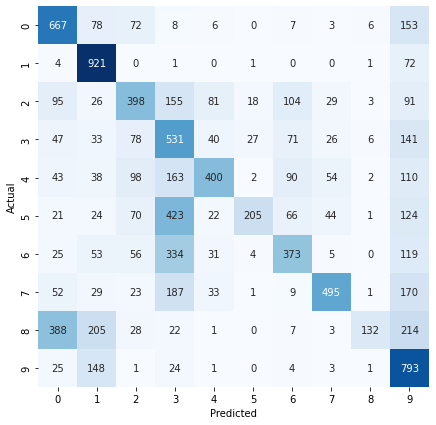

In [29]:
# Assuming you have a trained model and test data X_test
y_pred = VGG_model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

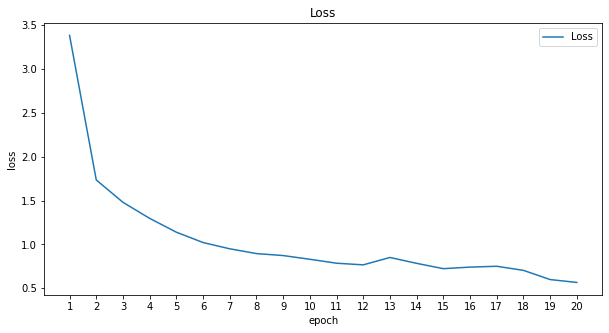

In [32]:
# reading the csv file
df = pd.read_csv('VGG_history.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='Loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

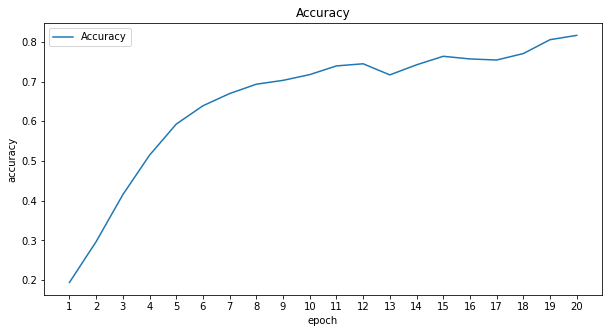

In [33]:
# reading the csv file
df = pd.read_csv('VGG_history.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='Accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()